In [0]:
from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from tqdm import tqdm
import numpy as np

## A1 - GAN optimization

Text(0, 0.5, 'V(x,y)')

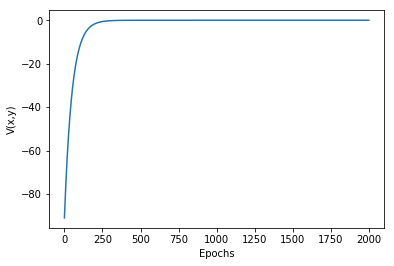

In [58]:
# define loss function V and gradient
V = lambda x,y: x*y
gradV = lambda x,y: np.array([y, x])
negGradV = lambda x,y: np.array([-y, -x])


def alternating_gradient_descent(epochs, learningrate):

  # initial value in 2D space
  X = np.random.normal(0,10,2)
  X = negGradV(X[0], X[1]) + X

  # perform gradient descent / ascent
  steps = range(epochs)
  traj = np.zeros([epochs,2])

  for s in steps:
    # ascent
    X = X - learningrate * gradV(X[0], X[1])

    # descent
    X = X - learningrate * negGradV(X[0], X[1])
    traj[s] = X

  return traj
    
  
epochs = 2000    
learningrate = 0.1 

traj = alternating_gradient_descent(epochs, learningrate)
V_traj = [V(traj[i][0], traj[i][1]) for i in range(len(traj))]


plt.plot(V_traj)
plt.xlabel("Epochs")
plt.ylabel("V(x,y)")

Late-time behaviour: The loss function V(x,y) converges to zero.

## A2 - GAN

In [0]:
size = 40

# evaluate polynomial over grid of size 40x40
def polynomial(degree):
    coeff = np.random.normal(0,1,(degree+1, degree+1))
    #coeff = np.random.uniform(-1,1,(degree+1, degree+1))
    return [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
            for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
            for x in range(size)] for y in range(size)]

# training set of polynomial images of degree <=5
maxdegree = 5
size = 40
num_polys = 3000
polydata = np.array([polynomial(np.random.randint(0,maxdegree)) for i in range(num_polys)])
polydata = tf.keras.utils.normalize(polydata)
#polydata = polydata.reshape(num_polys, size**2)
np.save('polydata.npy', polydata)

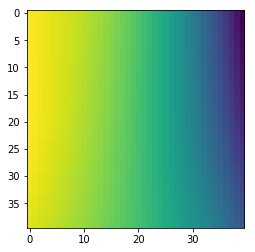

In [78]:
polydata = np.load('polydata.npy')
plt.imshow(polydata[3])

newarray= []

for img in polydata:
  newimg = img.reshape(-1)
  newarray.append(newimg)
  
polydata = newarray

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 1600)            

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  1%|          | 1/128 [00:00<00:22,  5.53it/s]

Epoch 2


  1%|          | 1/128 [00:00<00:22,  5.55it/s]

Epoch 3


  1%|          | 1/128 [00:00<00:22,  5.56it/s]

Epoch 4


  1%|          | 1/128 [00:00<00:22,  5.59it/s]

Epoch 5


  1%|          | 1/128 [00:00<00:23,  5.49it/s]

Epoch 6


  1%|          | 1/128 [00:00<00:23,  5.36it/s]

Epoch 7


  1%|          | 1/128 [00:00<00:23,  5.33it/s]

Epoch 8


  1%|          | 1/128 [00:00<00:23,  5.50it/s]

Epoch 9


  1%|          | 1/128 [00:00<00:23,  5.46it/s]

Epoch 10


  1%|          | 1/128 [00:00<00:23,  5.49it/s]

Epoch 11


  1%|          | 1/128 [00:00<00:23,  5.34it/s]

Epoch 12


  1%|          | 1/128 [00:00<00:24,  5.26it/s]

Epoch 13


  1%|          | 1/128 [00:00<00:22,  5.57it/s]

Epoch 14


  1%|          | 1/128 [00:00<00:23,  5.45it/s]

Epoch 15


  1%|          | 1/128 [00:00<00:22,  5.55it/s]

Epoch 16


  1%|          | 1/128 [00:00<00:22,  5.55it/s]

Epoch 17


  1%|          | 1/128 [00:00<00:22,  5.56it/s]

Epoch 18


  1%|          | 1/128 [00:00<00:24,  5.23it/s]

Epoch 19


  1%|          | 1/128 [00:00<00:22,  5.62it/s]

Epoch 20


100%|██████████| 128/128 [00:23<00:00,  5.45it/s]


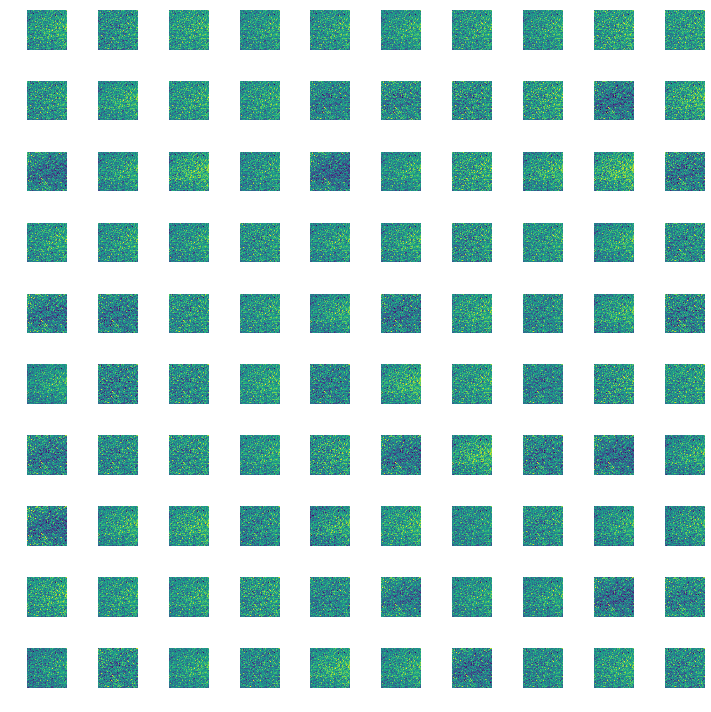

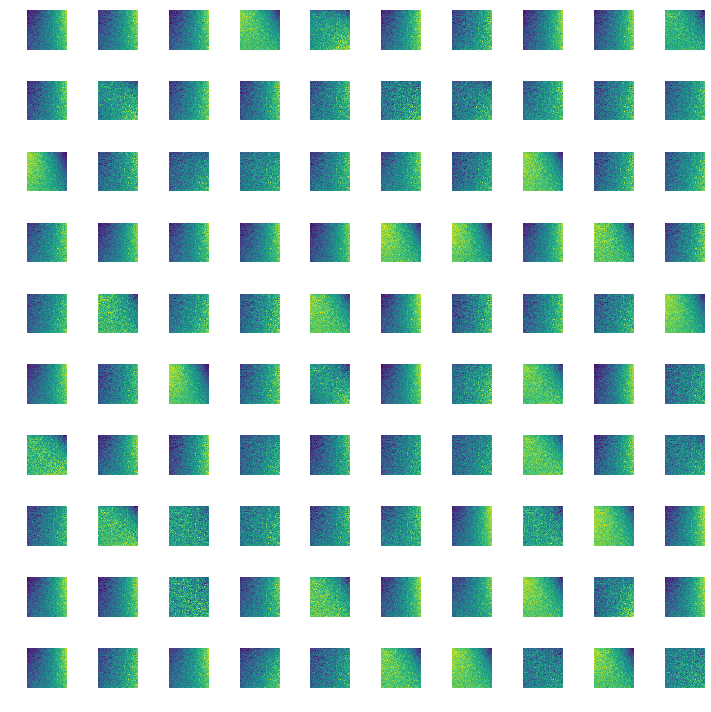

In [83]:
# Specifies optimizer
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)
  
# Generator network for GAN
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1600, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

# Generator network for GAN
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024, input_dim=1600))
    discriminator.add(LeakyReLU(0.2))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))

       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

# Creates GAN architecture
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

# Plots generated images every given number of epochs
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,40,40)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

def training(epochs, batch_size):
    
    X_train = np.array(polydata)
    print(X_train)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
            
training(20, 128)

The GAN is able to reproduce the 2D polynomials quite well after 20 epochs, even though the images are still quite pixelated.

In [80]:
# GAN implementation from lecture
# This doesn't work, but I don't know why!

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 40
        self.img_cols = 40
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = polydata
        
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
dcgan.train(epochs=4000, batch_size=32, save_interval=50)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 20, 20, 32)        320       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 11, 11, 64)      

ValueError: ignored